# Imports Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import optuna
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 1 Exploratory data analysis

**1.1 Load Data**

In [2]:
women_train = pd.read_csv('/kaggle/input/widsdatathon2024-challenge1/training.csv')
women_test = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/test.csv")
sample_submission = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/sample_submission.csv")


**1.2 train data info**

In [3]:
women_train.head(10)


,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0
5,111545,White,MEDICARE ADVANTAGE,NY,141,66,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,13.717143,8.888235,0.638235,25.000000,4.797143,7.745714,40.107248,6.181812,13.562528,0
6,914071,NaN,COMMERCIAL,CA,900,51,F,29.05,C50912,Malignant neoplasm of unspecified site of left...,...,11.901538,20.760000,14.737500,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261,1
7,479368,White,COMMERCIAL,IL,619,60,F,NaN,C50512,Malig neoplasm of lower-outer quadrant of left...,...,15.260000,10.890000,0.503333,24.275862,8.753333,7.506667,37.646770,7.295977,12.914805,1
8,994014,White,MEDICARE ADVANTAGE,NaN,973,82,F,NaN,1744,Malignant neoplasm of upper-outer quadrant of ...,...,19.371875,14.593651,1.620968,26.015254,6.645313,10.955385,36.323573,4.744352,10.439314,0
9,155485,NaN,COMMERCIAL,IL,617,64,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,...,11.816981,8.443396,0.190566,23.843396,4.684906,9.016981,37.773830,7.299998,14.942968,1


**1.3 Statistical summary**

In [4]:
women_train.describe().T.style.background_gradient(cmap='viridis', axis=0)

,count,mean,std,min,25%,50%,75%,max
patient_id,12906.000000,547381.196033,260404.959974,100063.000000,321517.000000,543522.000000,772671.750000,999896.000000
patient_zip3,12906.000000,573.754300,275.447534,101.000000,331.000000,554.000000,846.000000,999.000000
patient_age,12906.000000,59.183326,13.335216,18.000000,50.000000,59.000000,67.000000,91.000000
bmi,3941.000000,28.984539,5.696906,14.000000,24.660000,28.190000,32.920000,85.000000
population,12905.000000,20744.441237,13886.903756,635.545455,9463.896552,19154.190480,30021.278690,71374.131580
density,12905.000000,1581.950419,2966.305306,0.916667,171.857143,700.337500,1666.515385,21172.000000
age_median,12905.000000,40.502259,4.036963,20.600000,37.129825,40.639344,42.934783,54.570000
age_under_10,12905.000000,11.122784,1.512376,0.000000,10.160000,11.039216,12.190000,17.675000
age_10_to_19,12905.000000,12.945265,1.923974,6.314286,11.741176,12.923944,14.019767,35.300000
age_20s,12905.000000,13.290376,3.354103,5.925000,11.013415,12.538095,14.971053,62.100000


**1.4 Misssing values check**

In [5]:
print(women_train.isnull().sum())


patient_id           0
patient_race      6385
payer_type        1803
patient_state       51
patient_zip3         0
                  ... 
veteran              1
Ozone               29
PM25                29
N02                 29
DiagPeriodL90D       0
Length: 83, dtype: int64


In [6]:
print(women_test.isnull().sum())

patient_id             0
patient_race        2901
payer_type           760
patient_state         21
patient_zip3           0
                    ... 
health_uninsured       0
veteran                0
Ozone                 14
PM25                  14
N02                   14
Length: 82, dtype: int64


**1.5 Check feature types**

In [7]:
def get_feature_types(data):
    return {col: "numerical" if pd.api.types.is_numeric_dtype(data[col]) else "categorical" for col in data}

print("\n".join(f"{col}: {feat_type}" for col, feat_type in get_feature_types(women_train).items()))


patient_id: numerical
patient_race: categorical
payer_type: categorical
patient_state: categorical
patient_zip3: numerical
patient_age: numerical
patient_gender: categorical
bmi: numerical
breast_cancer_diagnosis_code: categorical
breast_cancer_diagnosis_desc: categorical
metastatic_cancer_diagnosis_code: categorical
metastatic_first_novel_treatment: categorical
metastatic_first_novel_treatment_type: categorical
Region: categorical
Division: categorical
population: numerical
density: numerical
age_median: numerical
age_under_10: numerical
age_10_to_19: numerical
age_20s: numerical
age_30s: numerical
age_40s: numerical
age_50s: numerical
age_60s: numerical
age_70s: numerical
age_over_80: numerical
male: numerical
female: numerical
married: numerical
divorced: numerical
never_married: numerical
widowed: numerical
family_size: numerical
family_dual_income: numerical
income_household_median: numerical
income_household_under_5: numerical
income_household_5_to_10: numerical
income_household_

# 2 Data Viz


**2.1  correlation between air quality indicators (ozone, PM25, NO2) and the likelihood of a timely cancer diagnosis?**


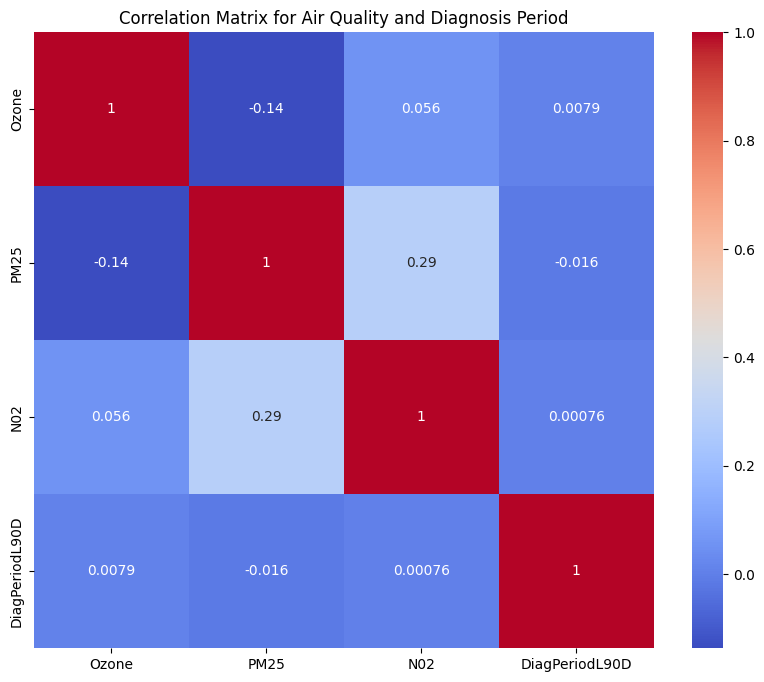

In [8]:
correlation_matrix = women_train[['Ozone', 'PM25', 'N02', 'DiagPeriodL90D']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Air Quality and Diagnosis Period')
plt.show()


**2.2 Count the occurrences of each payer type**

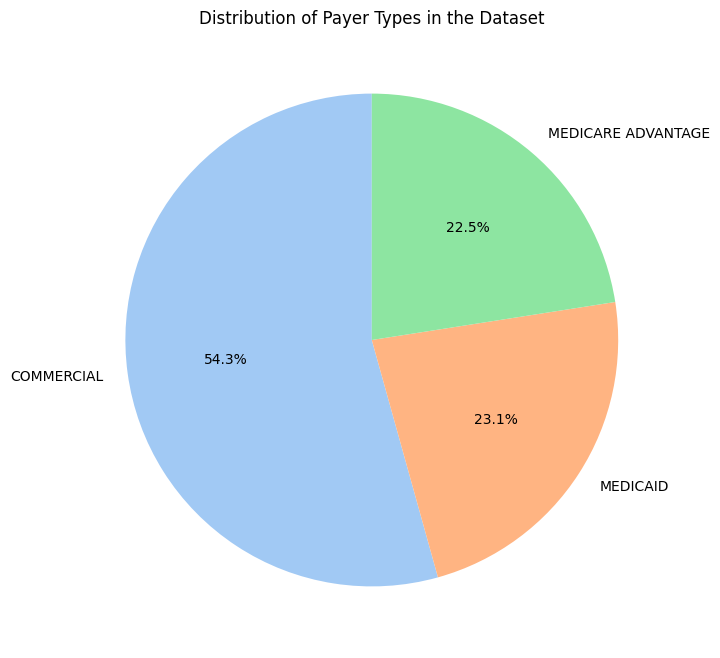

In [9]:

payer_counts = women_train['payer_type'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(payer_counts, labels=payer_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution of Payer Types in the Dataset')
plt.show()


**2.3 relationship between socioeconomic factors (income, education) and the diagnosis period?**


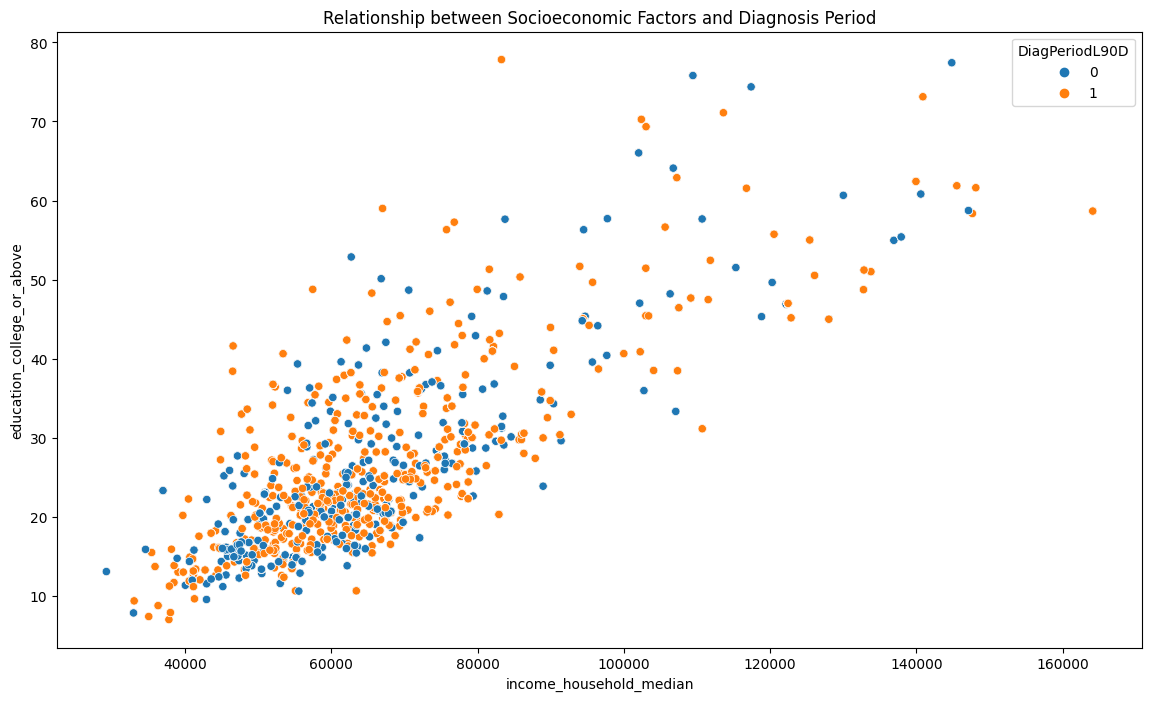

In [10]:

plt.figure(figsize=(14, 8))
sns.scatterplot(x='income_household_median', y='education_college_or_above', hue='DiagPeriodL90D', data=women_train)
plt.title('Relationship between Socioeconomic Factors and Diagnosis Period')
plt.show()


**2.4 Count the occurrences of each race in the dataset**

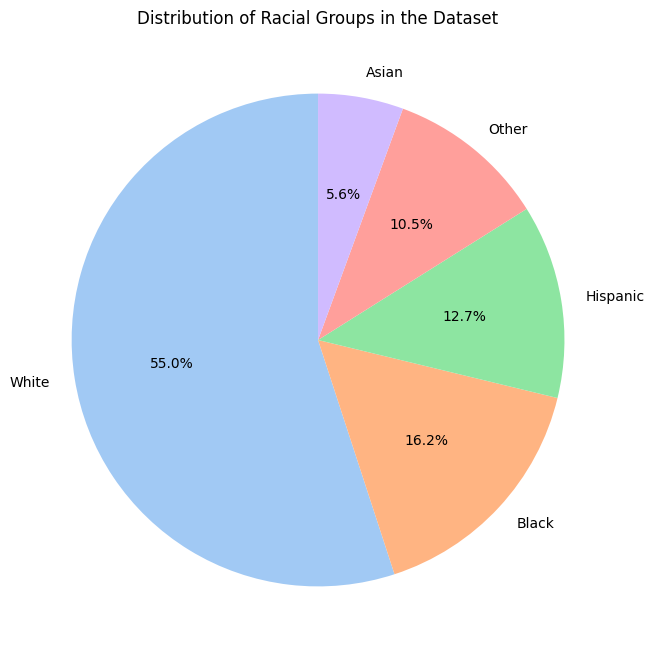

In [11]:
race_counts = women_train['patient_race'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution of Racial Groups in the Dataset')
plt.show()


# 3 Feature Engineering

**3.1 Drop unnecessary columns for modeling**

In [12]:
drop_columns = ['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']
women_train = women_train.drop(columns=drop_columns)
women_test = women_test.drop(columns=drop_columns)

**3.2 Define features and target variable**

In [13]:
X = women_train.drop(columns=['DiagPeriodL90D'])
y = women_train['DiagPeriodL90D']

**3.3 Split the data into training and validation sets**

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

**3.4 Preprocessing for numerical and categorical data**

In [15]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

**3.5 Bundle preprocessing for numerical and categorical data**

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


# 4 Model Building and Evaluation

**4.1 Define XGBoost model with Optuna hyperparameter optimization**

In [17]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'random_state': 42
    }

    xgb_model = XGBClassifier(**params)

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', xgb_model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_pred)

    return auc

**4.2 Create and run the Optuna study**

In [18]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

**4.3 Get the best parameters**

In [19]:
best_params = study.best_params

**4.3 Train XGBoost model with best hyperparametersl**

In [20]:
xgb_model = XGBClassifier(**best_params, random_state=42)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', xgb_model)])
clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['patient_id', 'patient_zip3', 'patient_age', 'bmi', 'population',
       'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s',
       'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80',
       'male', 'fe...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.01935662367057852, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=232,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

**4.4 Evaluate XGBoost model**

In [21]:
y_pred = clf.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, y_pred)
print(f'XGBoost: AUC = {auc:.4f}')

XGBoost: AUC = 0.8056


**4.5 Make predictions on test set**

In [22]:
final_predictions = clf.predict_proba(women_test)[:, 1]

# Prepare submission file

In [23]:
submission_df = pd.DataFrame({'patient_id': women_test['patient_id'], 'DiagPeriodL90D': final_predictions})
submission_df.to_csv('submission.csv', index=False)